In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
#Données compteurs
df1 = gpd.read_file("https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-compteurs/download/?format=geojson&timezone=Europe/Berlin&lang=fr")
df2 = df1.drop(['url_photos_n1', 'name', 'id', 'channel_id', 'installation_date', 'channel_name'], axis =1)
df2.rename(columns={'id_compteur': 'Identifiant du compteur'}, inplace=True)

In [4]:
#Données comptage + merge avec les données compteurs
df = pd.read_csv("https://raw.githubusercontent.com/linogaliana/python-datascientist/master/data/bike.csv", compression = "gzip")
df = df.merge(df2, how = 'left')

In [5]:
#On supprime les compteurs qui n'ont pas de geometry
def nogeo(df):
    nogeom = []
    for k in range(2):
        nogeom.append(df[df['geometry']==None].groupby('Identifiant du compteur')['Identifiant du compteur'].unique()[k][0])
    df = df[~df['Identifiant du compteur'].isin(nogeom)]
    
    return df

In [6]:
df = nogeo(df)

On se restreint aux variations sur la semaine. On considère que tous les mois sont pareils pour une première approche. Idée qu'un GPS ne fait pas forcément la différence entre août et septembre en terme de flux de cyclistes. 

In [7]:
df['deltah'] = df['Date et heure de comptage'].str[11:13]
df['date'] = pd.to_datetime(df['Date et heure de comptage'])
df['day'] = df.date.dt.day_name()

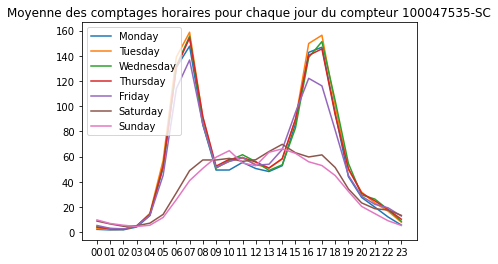

In [8]:
stock = df.copy()
toplot = stock[['Identifiant du compteur','Comptage horaire','day', 'deltah']].groupby(['Identifiant du compteur','day', 'deltah']).mean()
for k in np.random.choice(stock['Identifiant du compteur'].unique(),1):
    c = toplot.loc[k]
    fig, ax = plt.subplots()
    ax.plot(c.loc['Monday'], label = 'Monday')
    ax.plot(c.loc['Tuesday'], label = 'Tuesday')
    ax.plot(c.loc['Wednesday'], label = 'Wednesday')
    ax.plot(c.loc['Thursday'], label = 'Thursday')
    ax.plot(c.loc['Friday'], label = 'Friday')
    ax.plot(c.loc['Saturday'], label = 'Saturday')
    ax.plot(c.loc['Sunday'], label = 'Sunday')
    ax.legend(loc = 'upper left')
    plt.title(f'Moyenne des comptages horaires pour chaque jour du compteur {k}')

In [9]:
#Fonction qui sélectionne les lignes de df correspondant au jour et à l'heure de la requête 
def useful (df):
    #on trouve le jour de la requête 
    import datetime
    now = datetime.datetime.now()
    jour = []
    jour.append(now.strftime("%A"))
    
    #on trouve l'heure de la requête (merci Vinci)
    import time
    Time = time.strftime('%H:%M', time.localtime()) #Heure uniquement 
    heure = []
    heure.append(Time[:2])
    
    df = df[(df['deltah'].isin(heure))&(df['day'].isin(jour))]
    
    return df

In [10]:
df = useful(df)

In [11]:
#On calcule la moyenne horaire pour chaque compteur correspondant à l'heure et au jour de la requête
moyenne = df.groupby('Identifiant du compteur')[['Comptage horaire']].mean()

#On récupère les informations de df qui nous intéressent
info = df[['Identifiant du compteur', 'geometry', 'nom_compteur']] 
info = info.drop_duplicates() #on ne garde qu'une seule ligne pour chaque compteur 
info = info.set_index('Identifiant du compteur')

#on merge avec les moyennes horaires calculées 
final = moyenne.join(info)

In [12]:
#On crée un indice de congestion 
conditionlist = [
    (final['Comptage horaire'] >= 200), #congestion 
    ((final['Comptage horaire'] > 120) & (final['Comptage horaire'] < 200)), #fluide
    (final['Comptage horaire'] <= 120) #très fluide 
]
choicelist = ['red', 'orange','green']
final['congestion'] = np.select(conditionlist, choicelist, default = 'Not Specified')

In [13]:
final.groupby('congestion').count()

,Comptage horaire,geometry,nom_compteur
congestion,,,
green,93,93,93


In [14]:
#On récupère les coordonnées de chaque compteur sous une forme exploitable par folium
final['lat'] = [final['geometry'][i].x for i in final.index]
final['long'] = [final['geometry'][i].y for i in final.index]
final['lat'] = final['lat'].astype(str) 
final['long'] = final['long'].astype(str) 

**Compteurs pris en comtpe dans le trajet**

**/!\**
Hashtag à enlever pour faire fonctionner le notebook seule et à conserver pour faire fonctionner le notebook via le notebook final Trajet_GPS.

In [15]:
import folium
centre = (48.8534100,2.3488000)
idf = folium.Map(location = centre, zoom_start = 11) 

#import pyroutelib3
#from pyroutelib3 import Router
#import requests, json
#import urllib.parse

In [16]:
#adresse_depart = "17, Quai Panhard et Levassor, 75013 Paris"
#adresse_arrivee = "7, boulevard de l'Hôpital, 75013 Paris"
#dep_json = requests.get("https://api-adresse.data.gouv.fr/search/?q=" + urllib.parse.quote(adresse_depart) + "&format=json").json()
#arr_json = requests.get("https://api-adresse.data.gouv.fr/search/?q=" + urllib.parse.quote(adresse_arrivee) + "&format=json").json()
#coord_dep = list(dep_json['features'][0].get('geometry').get('coordinates'))
#coord_arr = list(arr_json['features'][0].get('geometry').get('coordinates'))

In [17]:
#centre = (48.8534100,2.3488000)
#idf = folium.Map(location = centre, zoom_start = 11) 

#coor_depart = [coord_dep[1], coord_dep[0]] 
#coor_arrivee = [coord_arr[1], coord_arr[0]] 

#folium.Marker(coor_depart,popup="Départ", color = 'red').add_to(idf)
#folium.Marker(coor_arrivee,popup="Arrivée", color = 'green').add_to(idf)

#router = pyroutelib3.Router("cycle")
#depart = router.findNode(coor_depart[0], coor_depart[1])
#print(depart)
#arrivee = router.findNode(coor_arrivee[0], coor_arrivee[1])
#print(arrivee)

#routeLatLons=[coor_depart,coor_arrivee]
#status, route = router.doRoute(depart, arrivee)
#if status == 'success':
#  print("votre trajet existe")
#  routeLatLons = list(map(router.nodeLatLon, route))
#else:
#  print("votre trajet n'existe pas")


#for coord in routeLatLons:
 # coord=list(coord)
  #folium.CircleMarker(coord,radius = 3,fill=True, color='blue').add_to(idf)

#folium.PolyLine(routeLatLons, color="blue", weight=2.5, opacity=1).add_to(idf)

In [18]:
#On garde seulement les compteurs éloignés de moins de 50m du trajet 
#length = []
#tokeep = []
#for i in final.index : 
#    for k in routeLatLons : 
#        dist = (k[0]-float(final['long'][i]))**2 + (k[1]-float(final['lat'][i]))**2
#        dist = dist**1/2*100
#        if dist < 0.005:
#            length.append(dist)
#            tokeep.append(i)
            
#tokeep = list(set(tokeep)) #on ne garde qu'une fois chaque nom de compteur

In [19]:
#Fonction qui place un marqueur pour chaque compteur de la couleur de l'indice de congestion associé
def circle (data):
    for i in data.index: #pour afficher tous les compteurs : remplacer data.index par tokeep
        coord = []
        lat = float(data.loc[i]['lat'])
        long = float(data.loc[i]['long'])
        coord.append(long)
        coord.append(lat)
        folium.Circle(coord,radius = 200,fill=True, color = data.loc[i]['congestion'], fill_color=data.loc[i]['congestion'], popup = data.loc[i]['nom_compteur']).add_to(idf)

In [20]:
circle(final)

In [33]:
#Ajout d'une légende 
import branca
from branca.element import Template, MacroElement

loc = 'Estimation de la congestion mesuree par les compteurs au moment de la requete'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)  

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 1);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Indice de congestion des pistes</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:green;opacity:0.6;'></span>Fluide</li>
    <li><span style='background:orange;opacity:0.6;'></span>Passant</li>
    <li><span style='background:red;opacity:0.6;'></span>Congestion</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 16px;
    border-radius: 8px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

idf.get_root().add_child(macro)
idf.get_root().html.add_child(folium.Element(title_html))
idf